In [1]:
import gym
import torch
from darc import DARC
from sac import ContSAC
from broken_joint import BrokenJointEnv
import matplotlib.pyplot as plt
import numpy as np
from utils import *

env_name = 'HalfCheetah-v2'
source_env = BrokenJointEnv(gym.make(env_name), [0])
target_env = gym.make(env_name)

state_dim = source_env.observation_space.shape[0]
action_dim = source_env.action_space.shape[0]
print('state dim is: {} and action dim is: {}'.format(state_dim, action_dim))

device = 'cuda'

state dim is: 17 and action dim is: 6


In [2]:
policy_config = {
    "input_dim": [state_dim],
    "architecture": [{"name": "linear1", "size": 256},
                     {"name": "linear2", "size": 256},
                     {"name": "split1", "sizes": [action_dim, action_dim]}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
value_config = {
    "input_dim": [state_dim + action_dim],
    "architecture": [{"name": "linear1", "size": 256},
                     {"name": "linear2", "size": 256},
                     {"name": "linear2", "size": 1}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
sa_config = {
    "input_dim": [state_dim + action_dim],
    "architecture": [{"name": "linear1", "size": 64},
                     {"name": "linear3", "size": 2}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
sas_config = {
    "input_dim": [state_dim * 2 + action_dim],
    "architecture": [{"name": "linear1", "size": 64},
                     {"name": "linear3", "size": 2}],
    "hidden_activation": "relu",
    "output_activation": "none"
}

# broken source

In [3]:
env_name = 'HalfCheetah-v2'
source_env = BrokenJointEnv(gym.make(env_name), [0])
target_env = gym.make(env_name)

state_dim = source_env.observation_space.shape[0]
action_dim = source_env.action_space.shape[0]
print('state dim is: {} and action dim is: {}'.format(state_dim, action_dim))

state dim is: 17 and action dim is: 6


In [4]:
# set current device
torch.cuda.set_device(0)
device = 'cuda'

In [5]:
running_state = ZFilter((state_dim,), clip=10)
model = DARC(policy_config, value_config, sa_config, sas_config, source_env, target_env, "cuda", ent_adj=True,
             n_updates_per_train=1,lr=3e-4,max_steps=1000,batch_size=256,
             savefolder='broken_source_half_cheetah_1000steps',running_mean=running_state,if_normalize = True)

src, tgt = model.train(5000, deterministic=False)

TARGET: index: 0, steps: 1000, total_rewards: -350.4038082312412
SOURCE: index: 0, steps: 1000, total_rewards: -362.6574244391412
TARGET: index: 1, steps: 1000, total_rewards: -274.2447174020139
SOURCE: index: 1, steps: 1000, total_rewards: -270.7865538709744
TARGET: index: 2, steps: 1000, total_rewards: -309.9729298540253
SOURCE: index: 2, steps: 1000, total_rewards: -202.11282484175527
TARGET: index: 3, steps: 1000, total_rewards: -287.7830242168469
SOURCE: index: 3, steps: 1000, total_rewards: -226.1193781728856
TARGET: index: 4, steps: 1000, total_rewards: -261.4072731832179
SOURCE: index: 4, steps: 1000, total_rewards: -137.37432118061557
TARGET: index: 5, steps: 1000, total_rewards: -327.48447293356986
SOURCE: index: 5, steps: 1000, total_rewards: -333.1353505818639
TARGET: index: 6, steps: 1000, total_rewards: -347.6207806432545
SOURCE: index: 6, steps: 1000, total_rewards: -169.86327949835476
TARGET: index: 7, steps: 1000, total_rewards: -331.67645752265224
SOURCE: index: 7, st

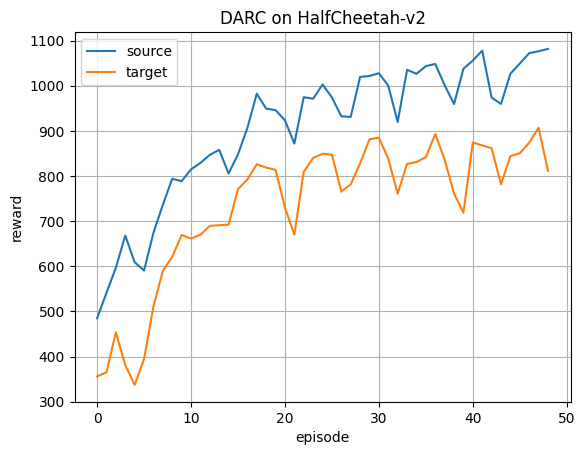

In [ ]:
length = list(range(len(src)))
plt.plot(length, src, label="source")
plt.plot(length, tgt, label="target")
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("DARC on HalfCheetah-v2")
plt.legend()
plt.grid()
plt.show()

# Sample Expert trajectory and save

In [ ]:
import gym
import argparse
import numpy as np
from darc import DARC
from broken_joint import BrokenJointEnv
import os
import torch
from utils import *
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import sys
import pickle
import time
from gail import GailContSAC_SRC
from src_gailsac_classifier import GailContSAC_SRC_Classifier

In [ ]:
render = 'store_true'
log_std = -0.0
gamma = 0.99
tau = 0.95
lr_reg = 1e-3
learning_rate = 5e-5
clip_epsilon = 0.01
num_threads = 1
seed = 1
min_batch_size = 2048
eval_batch_size = 2048
max_iter_num = 15000
log_interval = 1
save_model_path = ''
max_expert_state_num = 1000
train_steps = 2000
episode_length = 200
save_file_name = ''
optim_epochs = 3


env_name = "HalfCheetah-v2"
env = gym.make(env_name)

def lr_decay(actor_optim,cirtic_optim, total_steps,max_steps):
    if total_steps > 7000:
        lr_a_now = learning_rate * (1 - (total_steps-7000) /(max_steps))
        for p in actor_optim.param_groups:
            p['lr'] = lr_a_now
        for p in cirtic_optim.param_groups:
            p['lr'] = lr_a_now
    return actor_optim,cirtic_optim



In [ ]:
save_model = 'broken_source_half_cheetah_1000steps/4900'


expert_model = DARC(policy_config, value_config, sa_config, sas_config, source_env, target_env, device, ent_adj=True,
             n_updates_per_train=1, max_steps = 200, batch_size=256, savefolder ='none') 
expert_model.load_model(save_model, device)
expert_model.running_mean.fix = True


In [ ]:
num_steps = 0
expert_traj = []
total_reward = 0
from tqdm import tqdm

for i_episode in tqdm(range(100000)):

    state = source_env.reset()
    state = expert_model.running_mean(state)
    reward_episode = 0

    for t in range(episode_length):
        action = expert_model.get_action(state, deterministic=True)
        next_state, reward, done, _ = source_env.step(action)
        next_state = expert_model.running_mean(next_state)
        reward_episode += reward
        num_steps += 1

        expert_traj.append(np.hstack([state, next_state]))
        

        if done or num_steps >= max_expert_state_num:
            break


        state = next_state
    if num_steps >= max_expert_state_num:
        break
    total_reward += reward_episode

    # print('Episode {}\t reward: {:.2f} \t step : {}'.format(i_episode, reward_episode,t))
print('eval on src',total_reward/(i_episode))
expert_traj = np.stack(expert_traj)

total_reward = 0
num_steps = 0
for i_episode in tqdm(range(50)):
    state = target_env.reset()
    state = expert_model.running_mean(state)
    reward_episode = 0
    for t in range(episode_length):
        action = expert_model.get_action(state, deterministic=True)
        next_state, reward, done, _ = target_env.step(action)
        next_state = expert_model.running_mean(next_state)
        reward_episode += reward
        num_steps += 1
        if done or num_steps >= max_expert_state_num:
            break
        state = next_state
    if num_steps >= max_expert_state_num:
        break
    total_reward += reward_episode
print('eval on tgt',total_reward/(i_episode))

  0%|          | 4/100000 [00:01<7:26:08,  3.74it/s]


eval on src 1187.6476732754268


  8%|▊         | 4/50 [00:00<00:11,  4.06it/s]

eval on tgt 1158.2052212923943


In [ ]:
IL = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env,target_env, device,expert_traj,expert_model, ent_adj=True, n_updates_per_train=1,
                 batch_size=256,lr = 3e-4, max_steps = 1000, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,noise_scale = 1, update_freq = 100,
                                    if_normalize=True,)

src_bs, tgt_bs = IL.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -77.99502056461358, total_reward_adv: 191.3818, acc gen: 0, acc expert: 0
eval reward: -2.1903725181630502
index: 1, steps: 201, total_rewards: -6.790047959188702, total_reward_adv: 193.8434, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -27.107192729043028, total_reward_adv: 209.824, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -44.14096203960664, total_reward_adv: 239.3381, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -17.344000376635755, total_reward_adv: 188.0714, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -70.00203567542289, total_reward_adv: 195.5086, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -56.335308987067435, total_reward_adv: 190.6613, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -27.087425476463615, total_reward_adv: 251.5672, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -50.337160905433365, total_reward_adv: 

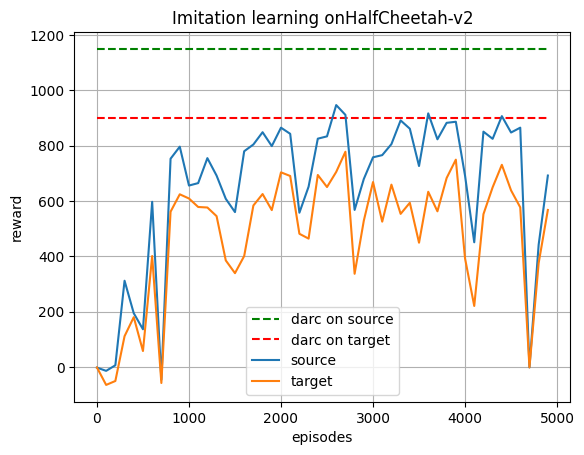

In [ ]:
length = np.array(list(range(len(src_bs)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 900

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs, label="source")
plt.plot(length, tgt_bs, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [ ]:
IL_2 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env,target_env, device,expert_traj,expert_model, ent_adj=True, n_updates_per_train=1,
                 batch_size=256,lr = 3e-4, max_steps = 1000, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,noise_scale = 1, update_freq = 1000,
                                    if_normalize=True,)

src_bs_2, tgt_bs_2 = IL_2.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -15.482004313530872, total_reward_adv: 135.6846, acc gen: 0, acc expert: 0
eval reward: -0.958057636775704
index: 1, steps: 201, total_rewards: -13.598973646993686, total_reward_adv: 139.9982, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -37.1915685280485, total_reward_adv: 139.14, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -40.26259036396756, total_reward_adv: 130.6163, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -64.09848873611037, total_reward_adv: 134.6367, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -87.27403985094551, total_reward_adv: 140.2636, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -66.27680079710409, total_reward_adv: 134.3276, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -70.83561202320824, total_reward_adv: 140.434, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -26.778166195582518, total_reward_adv: 133.06

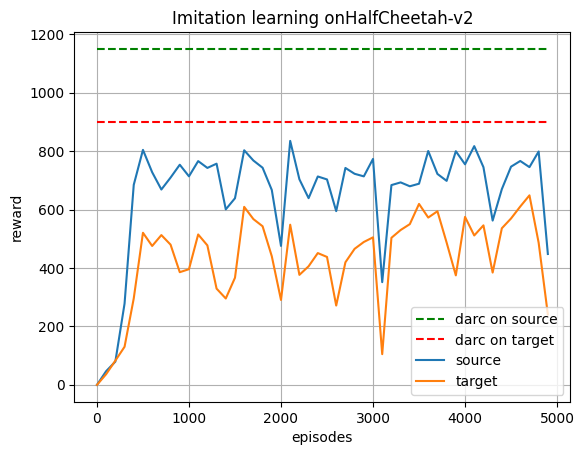

In [ ]:
length = np.array(list(range(len(src_bs_2)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 900

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_2, label="source")
plt.plot(length, tgt_bs_2, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [17]:
IL_3 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env,target_env, device,expert_traj,expert_model, ent_adj=True, n_updates_per_train=1,
                 batch_size=256,lr = 5e-5, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,noise_scale = 1, update_freq = 200,
                                    if_normalize=True,)

src_bs_3, tgt_bs_3 = IL_3.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -66.41908678220982, total_reward_adv: 133.8869, acc gen: 0, acc expert: 0
eval reward: -2.282317734838787
index: 1, steps: 201, total_rewards: -21.306246836049517, total_reward_adv: 130.3366, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -34.91591057075997, total_reward_adv: 126.3986, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -34.86385858506472, total_reward_adv: 138.7644, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -59.905388142536914, total_reward_adv: 130.4232, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -6.268649184236201, total_reward_adv: 136.3139, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -39.40326972009612, total_reward_adv: 162.6064, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -57.04023769568016, total_reward_adv: 125.2989, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -83.98479979490283, total_reward_adv: 131

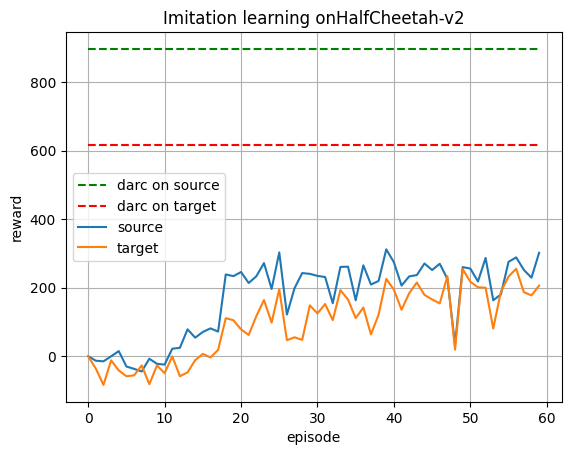

In [ ]:
length = np.array(list(range(len(src_bs_3)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 900

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_3, label="source")
plt.plot(length, tgt_bs_3, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()